# Analyzing Trends in the Tropical Pacific

#### Fall 2020 RCES Final Project
#### Max Elling


##### Question: 
Are trends in the tropical Pacific signaling a slowing Walker Circulation?
##### Summary:

This was inspired by Clara Deser's 2010 paper ["Twentieth century Tropical sea surface temperature trends revisited."](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010GL043321) Deser provides an analysis of trends in SST, SLP, cloudiness, and precipitation over the Tropical Pacific in the 20th century. The data provides evidence of a weakening Walker Circulation.

I used a similar approach to Deser to analyze trends in SST, SLP, cloudiness, and precipitation; however, there are some differences. I used the NOAA ERSST v5 SST dataset to uncover the differences in analysis between different datasets, and had an additional 12 years of data for cloudiness and SLP, and 6 for SST. Representations in my figures show similar trends to those in Deser's paper, but vary due to selection and breadth of datasets. 

##### Datasets:
- ICOADS 2 Degree Monthly Cloudiness (1900 - 2020)
- ICOADS 2 Degree Monthly Sea Level Pressure (1900 - 2020)
- NOAA ERSST v5 Monthly Mean SST (1920 - 2020)
- Palmer Drought Severity Index (PDSI) (1950-2014)


#### Imports

In [41]:
import xarray as xr
from datetime import datetime
import numpy as np
import pandas as pd
from IPython import display 
from matplotlib import pyplot as plt
import cftime # Used to clean up 'time' data
import cartopy.crs as ccrs
import cartopy
import warnings
warnings.filterwarnings("ignore") # Ignores warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Data

In [42]:
url_sst = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
url_cld = 'http://psl.noaa.gov/thredds/dodsC/Datasets/icoads/2degree/enh/cldc.mean.nc'
url_pdsi = 'https://psl.noaa.gov/thredds/dodsC/Datasets/dai_pdsi/pdsi.mon.mean.selfcalibrated.nc'
url_slp = 'https://psl.noaa.gov/thredds/dodsC/Datasets/icoads/2degree/enh/slp.mean.nc'

## Why is the Walker Circulation Important?

Changes in the strength of the Walker Circulation correspond with changes in trade winds, coastal upwelling, and other components that typically influence ENSO. ENSO is the most prominent mode of seasonal to interannual climate variability. Analyzing trends in the Tropical Pacific is important because it can help us understand how ENSO is responding to global warming. Global teleconnections between ENSO and drought are displayed below.

#### Teleconnections between ENSO and Drought

##### ERSST v5 SST DATA

In [43]:
ds_sst = xr.open_dataset(url_sst, drop_variables=['time_bnds'])
ds_sst = ds_sst.sel(time=slice('1920', None)).load()
ds_sst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 1211)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1920-01-01 1920-02-01 ... 2020-11-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:             89.0
    geospatial_laty_min:             -89.0
    geospatial_lat_max:              89.0
    geospatial_lat_min:              -89.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    cdm_data_type:                   Grid
    project:                         NOAA Extended Reconstructed Sea Surface ...
    original_publisher_url:          http://www.ncdc.noaa.gov
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    title:                           NOAA ERSSTv5 (in situ only)
    history:                         created 07/2017 by PSD data using NCEI's...
    institution:                     This version written at NOAA/ESRL PSD: o...
    citation:                        Huang et al, 2017: Extended Reconstructe...
    platform:                        Ship and Buoy SSTs from ICOADS R3.0 and ...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    processing_level:                NOAA Level 4
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   :metadata_link = https://doi.org/10.7289...
    creator_name:                    Boyin Huang (original)
    date_created:                    2017-06-30T12:18:00Z (original)
    product_version:                 Version 5
    creator_url_original:            https://www.ncei.noaa.gov
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2020-12-07
    DODS_EXTRA.Unlimited_Dimension:  time

In [44]:
# Grouping by month and removing climatology to get anomaly
sstgb = ds_sst.groupby('time.month')
sst_anom = sstgb - sstgb.mean(dim='time')

# An ONI ENSO phase is defined by 5 consective 3-month running mean SST of at least (+-) 0.5°C in the Niño 3.4 region 
sst_anom_rolling = sst_anom.rolling(time=3, center=True).mean()

# Creating latitude and longitude masks to get Niño 3.4 region (5S - 5N, 170W - 120W)
lonmaskL = ds_sst.lon <= 240
lonmaskH = ds_sst.lon >= 190

latmaskL = ds_sst.lat >= -5
latmaskH = ds_sst.lat <= 5

# Getting the 3-month running mean in the Niño 3.4 region
sst_masked_mean = sst_anom_rolling.where(lonmaskL & lonmaskH & latmaskL & latmaskH).mean(dim=('lon', 'lat'))

# Finding positive and negative ENSO Phases
pos_phase = (sst_masked_mean.sst >= 0.5).rolling(time=5, center=True).sum() == 5
neg_phase = (sst_masked_mean.sst <= -0.5).rolling(time=5, center=True).sum() == 5

#### PDSI Data
The Palmer Drought Severity Index measures soil moisture using precipitation and temperature data. Analyzing ENSO impacts on PDSI demonstrates how changes in ENSO can significantly impact things like agriculture and water scarcity. Negative PDSI anomalies are dry and positive anomalies are wet.

In [45]:
pdsi = xr.open_dataset(url_pdsi)

# Slicing data at 1950 for consistency
pdsi = pdsi.sel(time=slice('1920', None)).load(na_values=-99999.0)
pdsi

<xarray.Dataset>
Dimensions:  (lat: 55, lon: 144, time: 1140)
Coordinates:
  * lon      (lon) float32 -178.75 -176.25 -173.75 ... 173.75 176.25 178.75
  * lat      (lat) float32 -58.75 -56.25 -53.75 -51.25 ... 71.25 73.75 76.25
  * time     (time) datetime64[ns] 1920-01-01 1920-02-01 ... 2014-12-01
Data variables:
    pdsi     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:                           Global Monthly Dai Palmer Drought Severi...
    history:                         created Apr 2013 from data at NCAR webpa...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    original_source:                 NCAR/UCAR: A Dai http://www.cgd.ucar.edu...
    comments:                        original creation date: Thu Oct 25 15:25...
    Conventions:                     COARDS
    details:                         see ncar for more detials and updates
    description:                     \nMonthly Self-calibrated Palmer Drought...
    dataset_title:                   Palmer Drought Severity Index
    DODS_EXTRA.Unlimited_Dimension:  time

In [46]:
# Grouping by month and removing climatology to get PDSI anomaly
pdsigb = pdsi.groupby('time.month')
pdsi_anom = pdsigb - pdsigb.mean(dim='time')

In [47]:
# Getting the PDSI during positive and negative phases
ninoPDSI=pdsi_anom.pdsi.where(pos_phase)
ninaPDSI=pdsi_anom.pdsi.where(neg_phase)

# Taking the mean PDSI of positive and negative ENSO phases
pdsininomean = ninoPDSI.mean(dim='time')
pdsininamean = ninaPDSI.mean(dim='time')

#### Regional impacts of ENSO on Soil Moisture

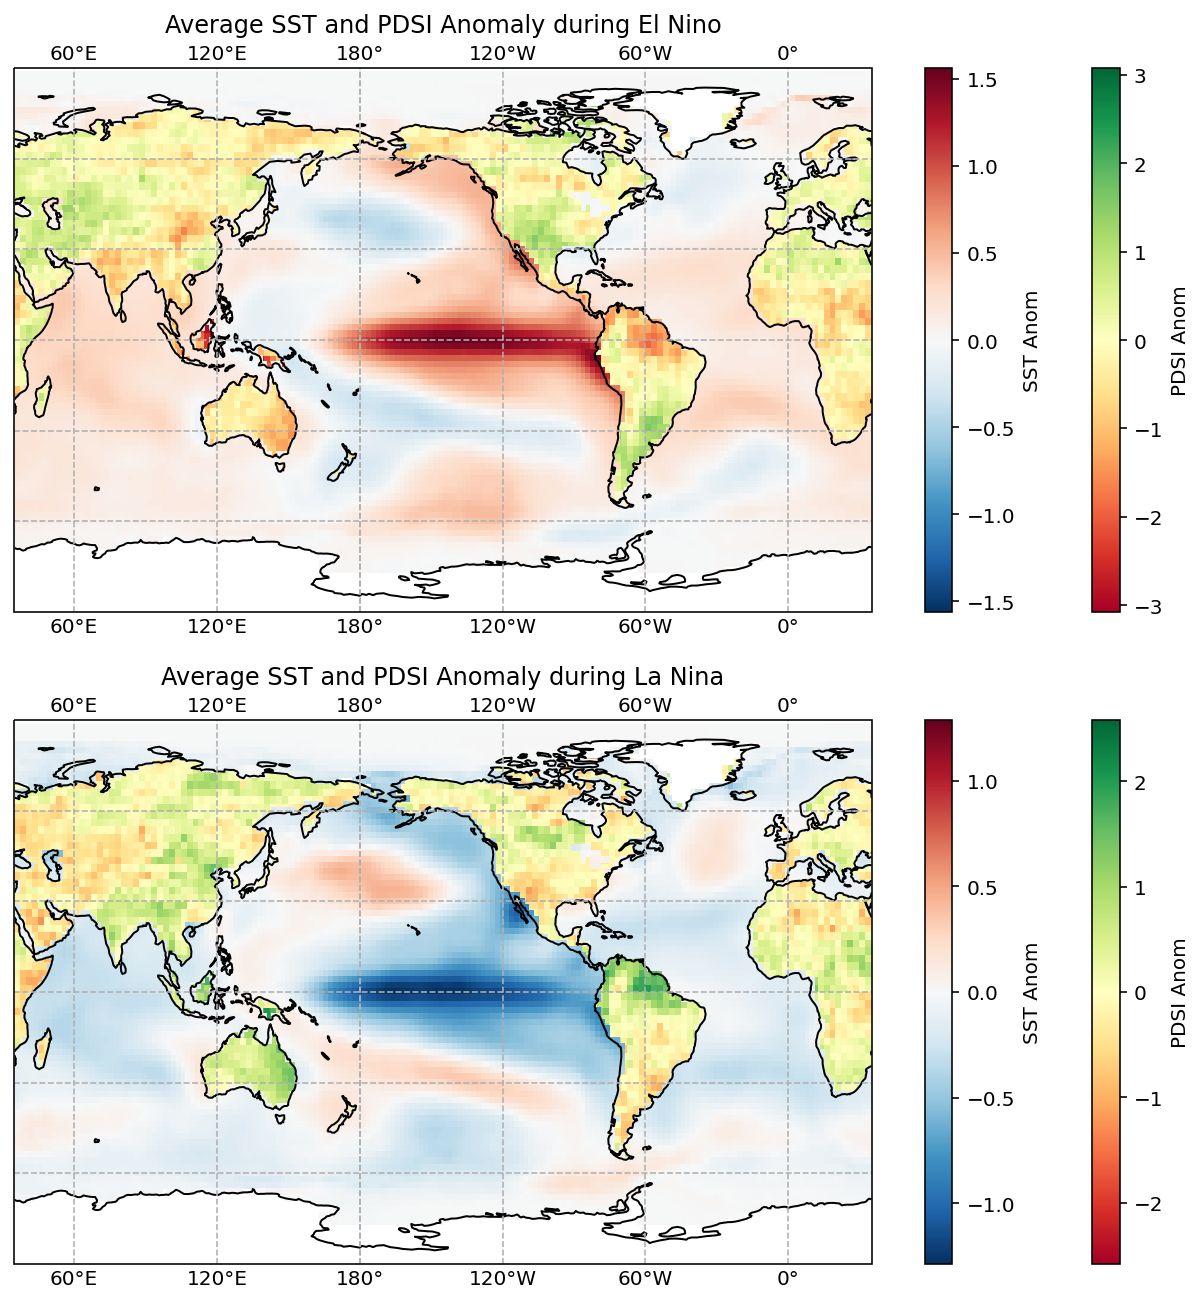

In [48]:
# Using matplotlib and cartopy to demonstrate the relationship between ENSO and PDSI
fig = plt.figure(figsize = (25, 10))
gs = fig.add_gridspec(2, 2)
plt.subplots_adjust(bottom = 0.05)
central_lon = -145

# El Nino/PDSI map
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_lon))
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
ax1.set_extent([-180,180, -90, 90], ccrs.PlateCarree())
pdsininomean.plot(cmap='RdYlGn', transform = ccrs.PlateCarree(), ax = ax1,
    cbar_kwargs={"orientation":"vertical","label": "PDSI Anom", "pad": 0.005})
sst_anom.sst.where(pos_phase).mean(dim='time').plot(transform=ccrs.PlateCarree(), ax = ax1,
       cbar_kwargs={"orientation":"vertical","label": "SST Anom", "pad": 0.05})
plt.title('Average SST and PDSI Anomaly during El Nino')
ax1.coastlines();
ax1.set_aspect('auto')

# La Nina/PDSI Map
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_lon))
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
ax2.set_extent([-180,180, -90, 90], ccrs.PlateCarree())
pdsininamean.plot(cmap='RdYlGn', transform = ccrs.PlateCarree(), ax = ax2,
    cbar_kwargs={"orientation":"vertical","label": "PDSI Anom", "pad": 0.005})
sst_anom.sst.where(neg_phase).mean(dim='time').plot(transform=ccrs.PlateCarree(),  ax = ax2,
    cbar_kwargs={"orientation":"vertical","label": "SST Anom", "pad": 0.05})
plt.title('Average SST and PDSI Anomaly during La Nina')
ax2.coastlines();
ax2.set_aspect('auto')

#### How does this relate to the Walker Circulation?
Mean Cloudiness during ENSO phases was calculated by masking by ONI defined ENSO phases and plotting the mean cloud cover for those periods. Normal mean cloudiness is the mean of SST for the dataset. 

In [49]:
# Opening ICOADS monthly cloudiness dataset
cld = xr.open_dataset(url_cld, decode_times=False)

# Converting the time coordinate from 'days since 1800-1-1 00:00:0.0' to Y/M/D format using cftime
todate_cld = cftime.num2date(cld['time'], 'days since 1800-1-1 00:00:0.0', '365_day')
cld['time'] = todate_cld

# Converting the time coordinate to datetime64
dt_cld = cld.indexes['time'].to_datetimeindex()
cld['time'] = dt_cld

# Slicing dataset to get data from 1900-present
cld = cld.sel(time=slice('1900', None)).load()

# Getting Mean Cloudiness during (+) and (-) ENSO Phases
meancldninoanom = cld.cldc.where(pos_phase).mean(dim='time')
meancldninaanom = cld.cldc.where(neg_phase).mean(dim='time')
meancldnorm = cld.cldc.mean(dim='time')

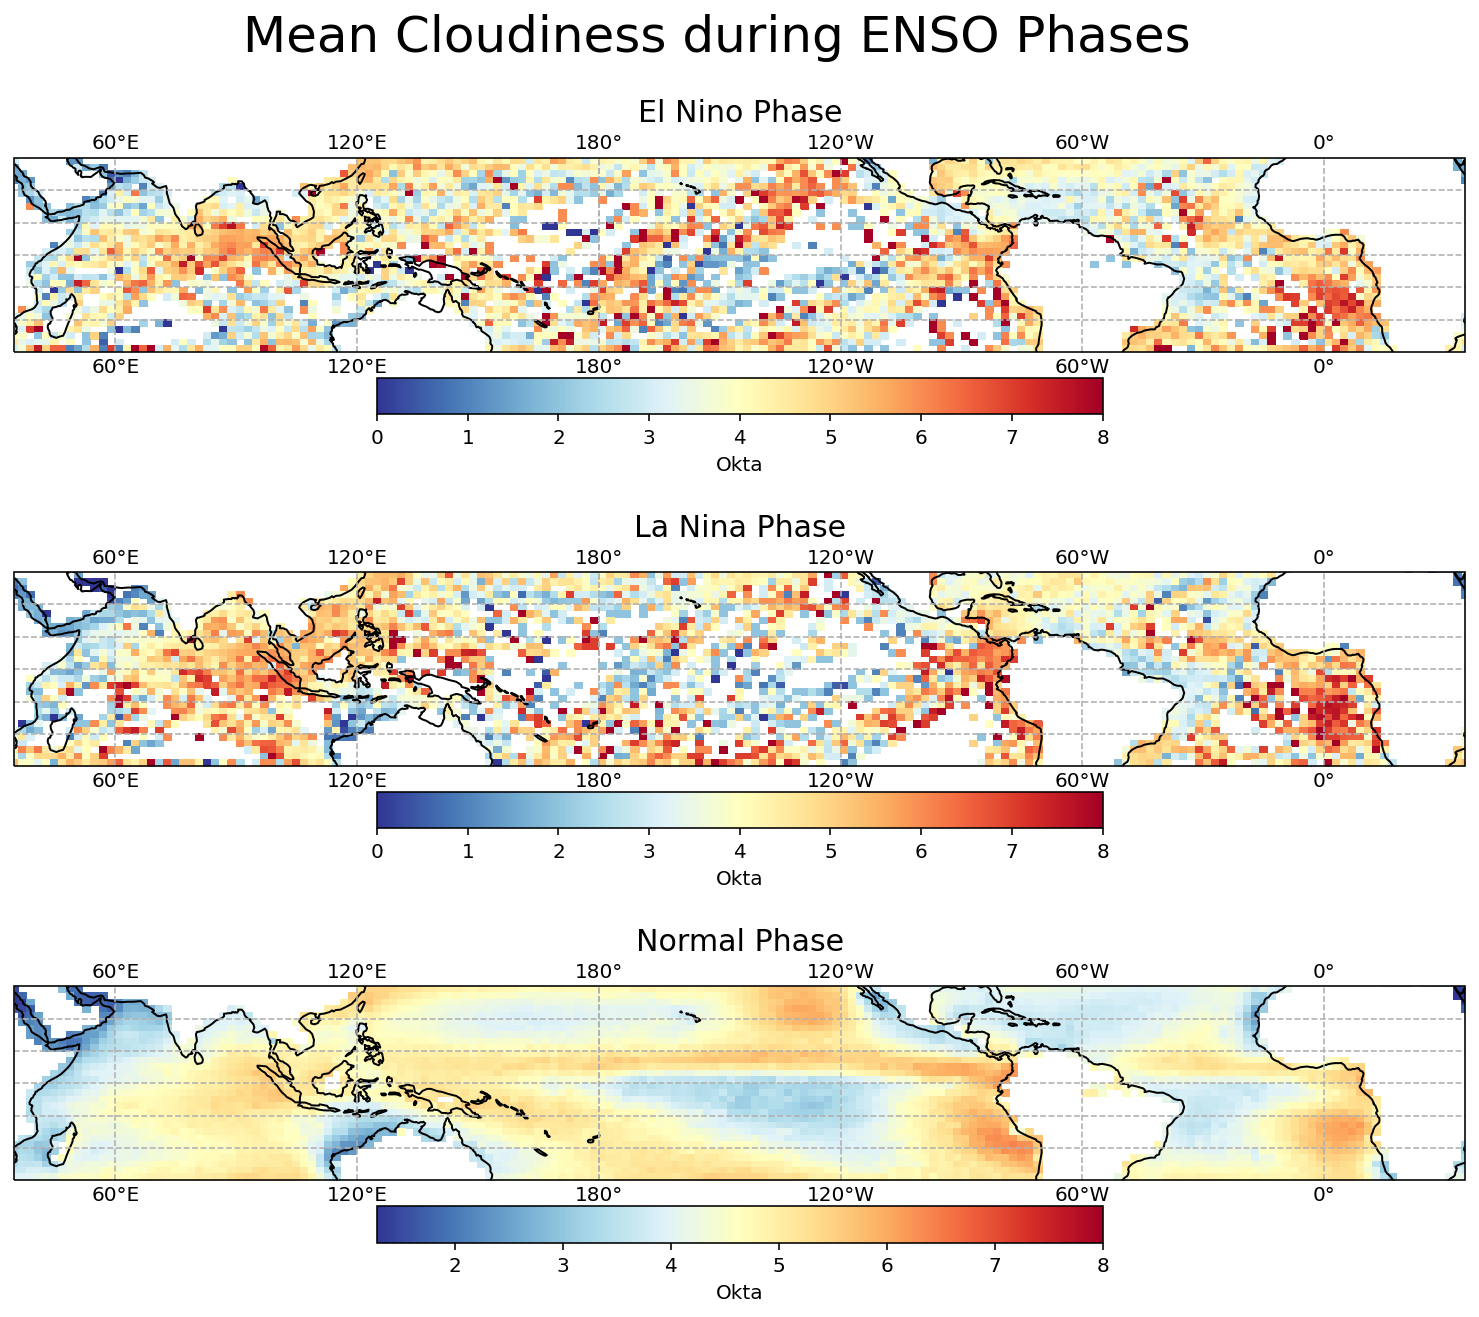

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (13, 10))
plt.suptitle('Mean Cloudiness during ENSO Phases', fontsize=25)
plt.subplots_adjust(hspace = 0.6)

# Cloudiness during La Nina Cloudiness
ax1 = plt.subplot(3, 1, 1, projection=ccrs.PlateCarree(central_lon))
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
ax1.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
meancldninoanom.plot(cmap='RdYlBu_r', transform = ccrs.PlateCarree(),
    cbar_kwargs={"orientation":"horizontal","label": "Okta", "pad": 0.1, "shrink": 0.5})
plt.title('El Nino Phase',fontsize = 15)
ax1.coastlines();
ax1.set_aspect('auto')

# Cloudiness during La Nina
ax2 = plt.subplot(3, 1, 2, projection=ccrs.PlateCarree(central_lon))
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
ax2.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
meancldninaanom.plot(cmap='RdYlBu_r', transform=ccrs.PlateCarree(),
    cbar_kwargs={"orientation":"horizontal", "label": "Okta", "pad": 0.1, "shrink": 0.5})
plt.title('La Nina Phase', fontsize = 15)
ax2.coastlines();
ax2.set_aspect('auto')


ax3 = plt.subplot(3, 1, 3, projection=ccrs.PlateCarree(central_lon))
ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
ax3.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
meancldnorm.plot(cmap='RdYlBu_r', transform=ccrs.PlateCarree(),
    cbar_kwargs={"orientation":"horizontal","label": "Okta", "pad": 0.1, "shrink": 0.5})
plt.title('Normal Phase', fontsize = 15)
ax3.coastlines();
ax3.set_aspect('auto')

## Analyzing Trends in SST, Cloudiness and SLP Data

#### Methods
I used polyfit to create a linear regression using time as the predictor. The time coefficient at each grid cell represents the change per increase in time increment for each variable, which I used a measurement of trend. I subtracted the average trend from the Tropical Pacific to remove artificial trends due to changes in observational practices, as done by Deser et al.

### Trends in SST 1920-2020

In [51]:
# Slicing dataset to get data from 1920-present
sst_trend = ds_sst

# Adding a time coordinate "months" since 1920/01 to use in the regresion (Cannot use datetime64 in polyfit)
sst_trend = sst_trend.assign(months = np.arange(1,len(sst_trend.time)+1))
sst_trend

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, months: 1211, time: 1211)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1920-01-01 1920-02-01 ... 2020-11-01
  * months   (months) int64 1 2 3 4 5 6 7 ... 1205 1206 1207 1208 1209 1210 1211
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max:              359.0
    geospatial_laty_max:             89.0
    geospatial_laty_min:             -89.0
    geospatial_lat_max:              89.0
    geospatial_lat_min:              -89.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    cdm_data_type:                   Grid
    project:                         NOAA Extended Reconstructed Sea Surface ...
    original_publisher_url:          http://www.ncdc.noaa.gov
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    title:                           NOAA ERSSTv5 (in situ only)
    history:                         created 07/2017 by PSD data using NCEI's...
    institution:                     This version written at NOAA/ESRL PSD: o...
    citation:                        Huang et al, 2017: Extended Reconstructe...
    platform:                        Ship and Buoy SSTs from ICOADS R3.0 and ...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    processing_level:                NOAA Level 4
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   :metadata_link = https://doi.org/10.7289...
    creator_name:                    Boyin Huang (original)
    date_created:                    2017-06-30T12:18:00Z (original)
    product_version:                 Version 5
    creator_url_original:            https://www.ncei.noaa.gov
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2020-12-07
    DODS_EXTRA.Unlimited_Dimension:  time

In [52]:
# Defining the regression function
def trend_sst(x):
    reg = np.polyfit(sst_trend.months, x, 1)
    return xr.DataArray(reg[0])

In [53]:
# Getting slope at each grid cell using polyfit regression function define above
stack_sst = sst_trend.sst.stack(coords=['lat','lon'])
regress_sst = stack_sst.dropna(dim='coords').groupby('coords').apply(trend_sst)
regress_unstack_sst = regress_sst.unstack('coords')

# Removing the mean cloudiness trend from the Tropical Pacific region (30S-30N) from each gridcell
# This is to account for artificial trends caused by changes in observational practice
removetrop_sst = regress_unstack_sst- regress_unstack_sst.where((regress_unstack_sst.coords_level_0 > -30) & (regress_unstack_sst.coords_level_0 < 30)).mean()

# Multiplying regression coefficient by number of days to get the trend over ~ 120 years
sst_per_century = removetrop_sst*len(sst_trend.months)

## Cloudiness

##### Monthly mean cloudiness using ICOADS cloud cover data

In [54]:
cld = xr.open_dataset(url_cld, decode_times=False)

# Converting the time coordinate from 'days since 1800-1-1 00:00:0.0' to Y/M/D format using cftime
todate_cld = cftime.num2date(cld['time'], 'days since 1800-1-1 00:00:0.0', '365_day')
cld['time'] = todate_cld

# Converting the time coordinate to datetime64
dt_cld = cld.indexes['time'].to_datetimeindex()
cld['time'] = dt_cld

# Slicing dataset to get data from 1900-present
cld = cld.sel(time=slice('1900', None)).load()

# Taking the mean in 5 year intervals to help display trend
cld_res = cld.resample(time = '5Y').mean()

# Adding a time coordinate "months" since 1900/01 to use in the regresion (Cannot use datetime64 in polyfit)
cld = cld_res.assign(timeint = np.arange(1,len(cld_res.time)+1))

##### Regression function and trend calculation

In [55]:
# Defining the regression function:
def trend_cld(x):
    reg = np.polyfit(cld.timeint, x, 1)
    return xr.DataArray(reg[0])

In [56]:
# Getting slope at each grid cell using polyfit regression function define above
stack_cld = cld.cldc.stack(coords=['lat','lon'])
regress_cld = stack_cld.dropna(dim='coords').groupby('coords').apply(trend_cld)
regress_unstack_cld = regress_cld.unstack('coords')

# Removing the mean cloudiness trend from the Tropical Pacific region (30S-30N) from each gridcell
removetrop = regress_unstack_cld - regress_unstack_cld.where((regress_unstack_cld.coords_level_0 > -30) & (regress_unstack_cld.coords_level_0 < 30)).mean()

# Multiplying regression coefficient by number of days to get the trend over ~ 120 years
okta_per_121y = removetrop*(cld.timeint[-1])

#### SLP PRESSURE DATA

In [57]:
# Opening ICOADS monthly SLP dataset
slp=xr.open_dataset(url_slp, decode_times=False)

# Adding an time variable "days" since 1800 to use in the regresion (Cannot use datetime64 in polyfit)
slp = slp.assign(days = slp['time'])

# Converting the time coordinate from 'days since 1800-1-1 00:00:0.0' to Y/M/D format using cftime
todate_slp=cftime.num2date(slp['time'], 'days since 1800-1-1 00:00:0.0', '365_day')
slp['time']=todate_slp

# Converting the time coordinate to datetime64
dt_slp = slp.indexes['time'].to_datetimeindex()
slp['time'] = dt_slp

# Slicing dataset to get data from 1900-present
slp = slp.sel(time=slice('1900', None)).load()

# Taking the mean in 5 year intervals to remove noise/clarify trend
slp_res = slp.resample(time = '5Y').mean()

# Adding a time coordinate "months" since 1900/01 to use in the regresion (Cannot use datetime64 in polyfit)
slp = slp_res.assign(timeint = np.arange(1,len(slp_res.time)+1))

In [58]:
# Defining the regression function:
def trend_slp(x):
    reg = np.polyfit(slp.timeint, x, 1)
    return xr.DataArray(reg[0])

In [59]:
# Getting slope at each grid cell using polyfit regression function define abov
stack_slp = slp.slp.stack(coords=['lat','lon'])
regress_slp = stack_slp.dropna(dim='coords').groupby('coords').apply(trend_slp)
regress_unstackslp = regress_slp.unstack('coords')

# Removing the mean cloudiness trend from the Tropical Pacific region (30S-30N) from each gridcell
removetrop_slp = regress_unstackslp- regress_unstackslp.where((regress_unstackslp.coords_level_0 > -30) & (regress_unstackslp.coords_level_0 < 30)).mean()

# Multiplying regression coefficient by number of days to get the trend over ~ 120 years
slp_per_120y = removetrop_slp*(slp.timeint[-1])

### Tropical Climate Trends, 20th-21st Century 

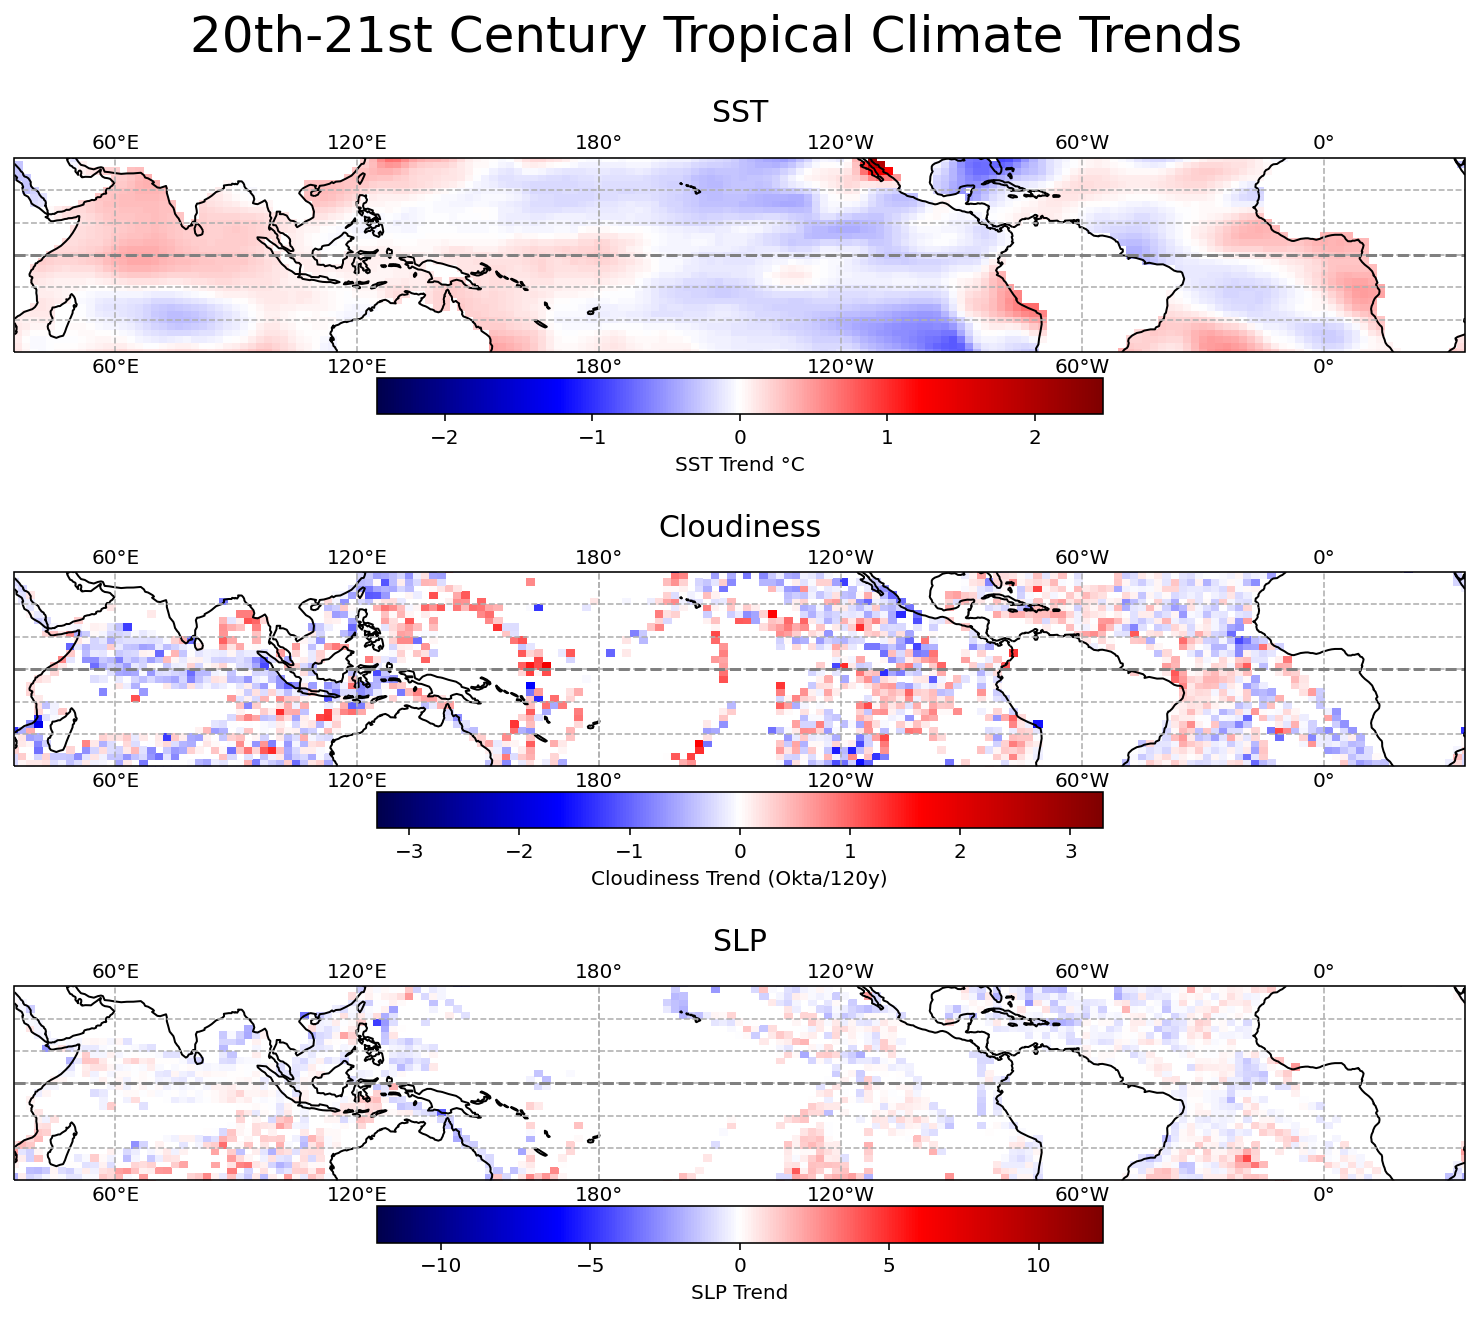

In [60]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (13, 10))
plt.suptitle('20th-21st Century Tropical Climate Trends', fontsize=25)
plt.subplots_adjust(hspace = 0.6)

# SST plot
ax1 = plt.subplot(3, 1, 1, projection = ccrs.PlateCarree(central_lon))
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
ax1.set_extent([-150, 150, -30, 30], ccrs.PlateCarree())
plt.axhline(y=0, color='gray', linestyle='--')
sst_per_century.plot(cmap='seismic',
                   transform = ccrs.PlateCarree(),
                   cbar_kwargs={"orientation":"horizontal", "label": "SST Trend °C", "pad": 0.1, "shrink": 0.5})
plt.title('SST', fontsize=15)
ax1.coastlines();
ax1.set_aspect('auto')


# Cloudiness plot
ax2 = plt.subplot(3, 1, 2, projection = ccrs.PlateCarree(central_lon))
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
ax2.set_extent([-150, 150, -30, 30], ccrs.PlateCarree())
okta_per_121y.plot(cmap = 'seismic',
             transform = ccrs.PlateCarree(),
             cbar_kwargs={"orientation":"horizontal", "label": "Cloudiness Trend (Okta/120y)", "pad": 0.1, "shrink": 0.5})
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Cloudiness', fontsize = 15)
ax2.coastlines();
ax2.set_aspect('auto')


#SLP plot
ax3 = plt.subplot(3, 1, 3, projection = ccrs.PlateCarree(central_lon))
ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
ax3.set_extent([-150, 150, -30, 30], ccrs.PlateCarree())
slp_per_120y.plot(cmap = 'seismic',
             transform = ccrs.PlateCarree(),
             cbar_kwargs={"orientation":"horizontal", "label": "SLP Trend", "pad": 0.1, "shrink": 0.5})
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('SLP', fontsize = 15)
ax3.coastlines();
ax3.set_aspect('auto')

## Conclusions
There is an eastward trend of cloudiness along the equatorial Pacific, signaling a potentially weakening Walker Circulation. While this is consistent with Deser's conclusions, the SLP and SST trends are less apparent from simple visual analysis. Differences in representations is likely be due to approach or breadth and selection of datasets. 